# Setting up Hyperparameters

In [1]:
epochs = 20
negative_mining = True
soft_labels = True
nb_augment = 0
load_data_on_GPU = True

In [2]:
batch_size = 1
learning_rate = 5e-4
loss_fn = None

### Selecting the correct device for training (CPU or GPU)

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Importing the Data

In [4]:
from Dataset import POCDataReader, data_augment_

data_reader = POCDataReader(root_dir="../data", load_on_gpu=load_data_on_GPU, limit=100)

train_data, val_data, test_data = data_reader.split([0.7, 0.1, 0.2])

data_augment_(train_data, n=nb_augment, load_on_gpu=load_data_on_GPU)

Loading dataset into GPU:   0%|          | 0/2744 [00:00<?, ?it/s]

	- Loading done, GPU memory used: 0.11GiB / free: 9.98GiB / total: 10.91GiB
	- Got a total of 100 images.


/home/tim/Documents/POC-Project/src/Dataset.py:36: UserWarning: Need a strictly positive integer for n for data augmentation. Will skip augmentation.
  warnings.warn("Need a strictly positive integer for n for data augmentation. Will skip augmentation.")


In [5]:
from torchvision.transforms.functional import invert
from torch.nn.functional import normalize

from pipelines import InputPipeline, LaplacianFilter, SobelFilter, DINOFilter

inpip = InputPipeline(
    transformer=[invert, normalize],
    layer_transformer=[
        LaplacianFilter(),
        SobelFilter(),
        DINOFilter()]
)

if load_data_on_GPU:
    inpip = inpip.to(device)

Using cache found in /home/tim/.cache/torch/hub/facebookresearch_dino_main


### Creating Training Dataset

In [6]:
from torch.nn.functional import normalize
from torchvision.transforms import GaussianBlur

from Dataset import POCDataset

train_dataset = POCDataset(
    train_data,
    transform=inpip,
    target_transform= GaussianBlur(kernel_size=3, sigma=0.7) if soft_labels else None,
    negative_mining=negative_mining,
)

# train_dataset.precompute_transform(load_data_on_GPU)

In [7]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
    )
else:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Validation Dataset

In [ ]:
from torch.nn.functional import normalize

from Dataset import POCDataset

val_dataset = POCDataset(val_data, transform=normalize, target_transform=None, negative_mining=False)

In [ ]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
    )
else:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Evaluation Dataset

In [ ]:
from torch.nn.functional import normalize

from Dataset import POCDataset

test_dataset = POCDataset(test_data, transform=normalize, target_transform=None, negative_mining=False)

In [ ]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
    )
else:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Testing the dataloader

torch.Size([1, 6, 480, 640]) torch.Size([1, 2, 480, 640])
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor([0.0000e+00, 8.5594e-04, 1.3733e-03,  ..., 9.3636e-01, 9.5304e-01,
        9.8605e-01], device='cuda:0')
('1191.png',) tensor([18])


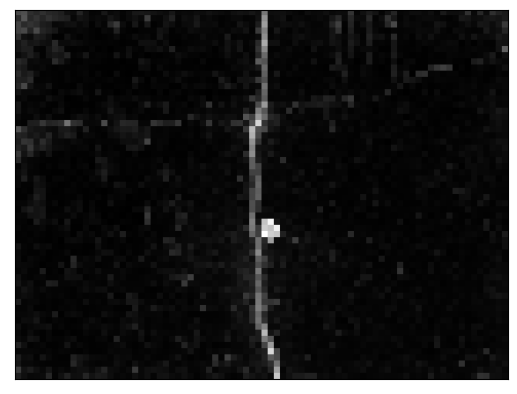

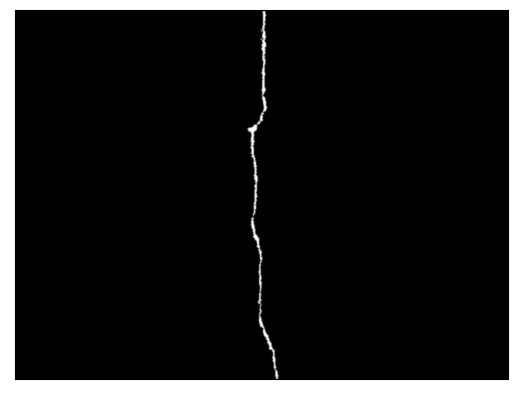

In [8]:
from my_utils import show_img

features, masks, files, indexes = next(iter(training_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files, indexes)

### Testing Dataset for proportion between classes

In [ ]:
_,train_labels,_,_ = next(iter(training_dataloader))

nb_pixel = torch.unique(train_labels, return_counts=True)[1]
print("Proportion of class 1 in this batch: {}%".format(nb_pixel[1] * 100 / (nb_pixel[0] + nb_pixel[1])))

Result is usually around 1.1% which may be too low for cross_entropy_loss.

# Building the differents modules

## Creating the models

#### Using Unet with bilinear upsampling and cropping to generate 2 classes (background and crack).

In [ ]:
from models import UNet

model = UNet(n_channels=1, n_classes=2, bilinear=True, crop=False).to(device)

In [ ]:
print("Total number of parameters: {0:,}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print(f"Model structure: {model}")

## Creating the loss functions

#### Cross Entropy Loss

In [ ]:
import torch
from torch.nn import CrossEntropyLoss

weight = torch.tensor([.9, .1])  # class weight : 98% for background and 2% for the cracks
loss_fn = CrossEntropyLoss(weight=weight).to(device)

#### Dice Loss

In [ ]:
from loss import DiceLoss

loss_fn = DiceLoss().to(device)

#### Focal Loss

In [ ]:
import torch
from loss import FocalLoss

weight = torch.tensor([.9, .1])  # class weight : 90% for background and 10% for the cracks
loss_fn = FocalLoss(weight=weight, gamma=2).to(device)

#### Jaccard Loss

In [ ]:
from loss import JaccardLoss

loss_fn = JaccardLoss().to(device)

#### Tversky Loss

In [ ]:
import torch
from loss import TverskyLoss

loss_fn = TverskyLoss(alpha=0.3, beta=0.7).to(device)

#### Focal Tversky Loss

In [ ]:
import torch
from loss import FocalTverskyLoss

loss_fn = FocalTverskyLoss(alpha=0.3, beta=0.7, gamma=2).to(device)

#### Combined (Focal + Tversky) Loss

In [ ]:
import torch
from loss import CombinedLoss, TverskyLoss, FocalLoss

weight = torch.tensor([.3, .7])

loss_fn = CombinedLoss(
    FocalLoss(weight=weight, gamma=2),
    TverskyLoss(alpha=0.3, beta=0.7),
    ratio=0.75).to(device)

#### Bordered (Focal + Tversky) Loss

In [ ]:
import torch
from loss import BorderedLoss, TverskyLoss, FocalLoss

weight = torch.tensor([.3, .7])

loss_fn = BorderedLoss(
    border_loss=FocalLoss(weight=weight, gamma=2),
    volume_loss=TverskyLoss(alpha=0.3, beta=0.7),
    ratio=0.5).to(device)

In [ ]:
print(loss_fn)

## Creating the Optimizer

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))

## Setting up the Learning Rate Scheduler

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs//2)

## Creating the Metrics

In [ ]:
from metrics import Metrics, EvaluationMetrics


train_metrics = Metrics(
    buffer_size=len(training_dataloader),
    mode="Training",
    model_name=model.__class__.__name__,
    loss_name=loss_fn.__class__.__name__,
    opt_name=optimizer.__class__.__name__,
    batch_size=batch_size,
    learning_rate=learning_rate,
    negative_mining=negative_mining,
    soft_labels=soft_labels,
    device=device)

val_metrics = Metrics(
    buffer_size=len(validation_dataloader),
    mode="Validation",
    model_name=model.__class__.__name__,
    loss_name=loss_fn.__class__.__name__,
    opt_name=optimizer.__class__.__name__,
    batch_size=batch_size,
    learning_rate=learning_rate,
    negative_mining=negative_mining,
    soft_labels=soft_labels,
    device=device)

test_metrics = EvaluationMetrics(
    buffer_size=len(evaluation_dataloader),
    model_name=model.__class__.__name__,
    loss_name=loss_fn.__class__.__name__,
    opt_name=optimizer.__class__.__name__,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    negative_mining=negative_mining,
    soft_labels=soft_labels,
    device=device)

# Training, testing and validating the Model

In [ ]:
from train_tqdm import training_loop, validation_loop, evaluation_loop

for epoch in range(1, epochs+1):
    training_loop(epoch, training_dataloader, model, loss_fn, optimizer, lr_scheduler, train_metrics, device)
    validation_loop(epoch, validation_dataloader, model, loss_fn, val_metrics, device)

evaluation_loop(evaluation_dataloader, model, test_metrics, device)

train_metrics.close_tensorboard()
val_metrics.close_tensorboard()
test_metrics.close_tensorboard()

In [ ]:
from pipelines.dino_vit_filter import DINOFilter

df = DINOFilter(1).to(device)

In [ ]:
from my_utils import show_img
from torch import nn

# features,_,_,_ = next(iter(training_dataloader))
# img = features.to(device)

res = df.forward(img=img)
    
show_img(res)